# As unsupervised problem
Unit 4 Lesson 4 Project 3

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to /Users/charla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/charla/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


# tfidf in sklearn

Happily for us, sklearn has a tfidf function that will do all our heavy lifting.  It also has a [very long list of stop words](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py).  Since we're going to be doing dimension reduction later on anyway, let's keep all the words for now.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


# Dimension reduction
Okay, now we have our vectors, with one vector per paragraph.  It's time to do some dimension reduction.  We use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity):

In [9]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.20203408416127
Component 0:
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
Oh !      0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634415
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.571683
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.561102
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .       

From gazing at the most representative sample paragraphs, it appears that component 0 targets the exclamation 'Oh!', component 1 seems to largely involve critical dialogue directed at or about the main character Emma, component 2 is chapter headings, component 3 is exclamations involving 'Ah!, and component 4 involves actions by or directly related to Emma.

What fun! 

# Sentence similarity

We can also look at how similar various sentences are to one another.  For example, here are the similarity scores (as a heatmap) of the first 10 sentences in the training set:

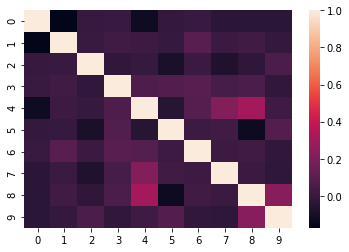

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [5]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

Not much similarity at all except between sentences 8 and 9, both of which seem to describe people getting along well.

# Drill 0: Test set

Now it's your turn: Apply our LSA model to the test set.  Does it identify similar sentences for components 0 through 4?  

In [11]:
# Remember, you will use the same model, only with the test set data.  Don't fit a new model by mistake!
#Reshapes the vectorizer output into something people can read
X_test_tfidf_csr = X_test_tfidf.tocsr()

#number of paragraphs
n_test = X_test_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
test_tfidf_bypara = [{} for _ in range(0,n_test)]
#List of features
test_terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    test_tfidf_bypara[i][test_terms[j]] = X_test_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_test[5])
print('Tf_idf vector:', test_tfidf_bypara[5])

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
test_svd= TruncatedSVD(130)
test_lsa = make_pipeline(test_svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_test_lsa = test_lsa.fit_transform(X_test_tfidf)

test_variance_explained=test_svd.explained_variance_ratio_
test_total_variance = test_variance_explained.sum()
print("Percent variance captured by all test components:",test_total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
test_paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('\nComponent {}:'.format(i))
    print(test_paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector: {'resolving': 0.3424390305045805, 'unexceptionable': 0.3196409792117937, 'assure': 0.267729777836069, 'friends': 0.2515333740641343, 'quite': 0.1916471918420347, 'replied': 0.20315405638674577, 'watch': 0.62300800500314, 'elton': 0.16874782424809767, 'pass': 0.28445227585106625, 'really': 0.21963852817625326, 'mrs': 0.14780961753993585}
Percent variance captured by all test components: 49.37543054292666

Component 0:
" Oh !         0.99992
" Me ! oh !    0.99992
" Oh !         0.99992
" Oh !"        0.99992
" Oh !         0.99992
" Oh !         0.99992
" Oh no !      0.99992
" Oh !         0.99992
" Oh !         0.99992
" Oh !         0.99992
Name: 0, dtype: float64

Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them ,

From gazing at the most representative sample paragraphs, it appears that component 0 targets the exclamation 'Oh!', component 1 seems to largely involve critical dialogue directed at or about the main character Emma, component 2 is chapter headings, component 3 is exclamations involving 'Ah!, and component 4 involves actions by or directly related to Emma.

What fun! 

# Sentence similarity

We can also look at how similar various sentences are to one another.  For example, here are the similarity scores (as a heatmap) of the first 10 sentences in the training set:

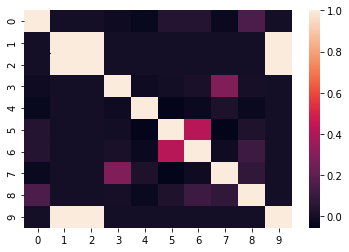

Key:
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comfo

In [7]:
# Compute document similarity using LSA components
test_similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
#Only taking the first 10 sentences
test_sim_matrix=pd.DataFrame(test_similarity,index=X_test).iloc[0:10,0:10]
#Making a plot
test_ax = sns.heatmap(test_sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,test_sim_matrix.index[i])

There is similarity between 1,2,9 becasue of the word 'Oh', other than that not much similarity.

# Drill 1: Tweaking tf-idf

Go back up to the code where we originally translated the text from words to numbers.  There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well.  We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities.  Change things up a few times and see how that affects the results of the LSA.  Write up your observations and share them with your mentor.

In [41]:
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nlp = spacy.load('en')


spaCy on the paragraphs and remove all the punctuation, stop words, digits, pronouns and titles.

In [69]:
#reading in the data, this time in the form of paragraphs
emma_nlp_doc=[]
for paragraph1 in emma_paras:
    emma_nlp_doc.append(nlp(paragraph1))
#emma1=gutenberg.paras('austen-emma.txt')

#processing
emma_paras1=[]
for paragraph1 in emma_nlp_doc:
    words = " ".join([token.lemma_.lower()
                for token in paragraph1
                if not token.is_punct
                and not token.lemma_.lower() in stopwords.words('english')
                and not token.is_digit
                and not token.lemma_ == '-PRON-'
                and not token.text.istitle()
                ])
    emma_paras1.append(words)
print(emma_paras1[0:4])

['', 'volume', 'chapter', 'handsome clever rich comfortable home happy disposition seem unite good blessing existence live nearly twenty one year world little distress vex']


Setting up function so that different parameters can be run to see what the different outcome will be.

In [79]:
def tfidf_svd(vectorizer):

    X_train1, X_test1 = train_test_split(emma_paras1, test_size=0.4, random_state=0)

    

    #Applying the vectorizer
    emma_paras_tfidf1=vectorizer.fit_transform(emma_paras1)
    print("\nNumber of features: %d" % emma_paras_tfidf1.get_shape()[1])

    #splitting into training and test sets
    X_train_tfidf1, X_test_tfidf1= train_test_split(emma_paras_tfidf1, test_size=0.4, random_state=0)


    #Reshapes the vectorizer output into something people can read
    X_train_tfidf_csr1 = X_train_tfidf1.tocsr()

    #number of paragraphs
    n1 = X_train_tfidf_csr1.shape[0]
    #A list of dictionaries, one per paragraph
    tfidf_bypara1 = [{} for _ in range(0,n1)]
    #List of features
    terms1 = vectorizer.get_feature_names()
    #for each paragraph, lists the feature words and their tf-idf scores
    for i, j in zip(*X_train_tfidf_csr1.nonzero()):
        tfidf_bypara1[i][terms[j]] = X_train_tfidf_csr1[i, j]

    #Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
    print('\nOriginal sentence:', X_train1[5])
    print('Tf_idf vector:', tfidf_bypara1[5])
    
    
    #Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
    svd1= TruncatedSVD(130)
    lsa1 = make_pipeline(svd1, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_train_lsa1 = lsa1.fit_transform(X_train_tfidf1)

    variance_explained1=svd1.explained_variance_ratio_
    total_variance1 = variance_explained1.sum()
    print("\nPercent variance captured by all components:",total_variance1*100)

    #Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
    paras_by_component1=pd.DataFrame(X_train_lsa1,index=X_train1)
    for i in range(5):
        print('\nComponent {}:'.format(i))
        print(paras_by_component1.loc[:,i].sort_values(ascending=False)[0:10])

Running the same parameters as the example above but this time we have incorporated spaCy to check for different spacCy attributes.

In [97]:
#same as above
vectorizer1 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
tfidf_svd(vectorizer1)


Number of features: 1483

Original sentence: minute however complete present trial
Tf_idf vector: {'hesitation': 0.5433044653685889, 'lasting': 0.539466850746499, 'calling': 0.6432695973355234}

Percent variance captured by all components: 46.31296237827964

Component 0:
get say could find                0.894712
see say                           0.894712
say                               0.894712
magnificent say                   0.894712
well go say                       0.894712
could say                         0.894712
say gently much                   0.894712
almost much relieve say           0.894712
misunderstanding say expressly    0.894712
say                               0.894712
Name: 0, dtype: float64

Component 1:
chapter        0.998888
chapter        0.998888
chapter        0.998888
chapter        0.998888
chapter        0.998888
chapter        0.998888
chapter        0.998888
chapter        0.998888
chapter        0.998888
chapter xii    0.997964
Name: 1, dtype: flo

In [107]:
# set max_df to 0.3 from 0.5
vectorizer2 = TfidfVectorizer(max_df=0.3, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
tfidf_svd(vectorizer2)


Number of features: 1483

Original sentence: minute however complete present trial
Tf_idf vector: {'hesitation': 0.5433044653685889, 'lasting': 0.539466850746499, 'calling': 0.6432695973355234}

Percent variance captured by all components: 46.320513410416496

Component 0:
well go say                       0.894592
say gently much                   0.894592
see say                           0.894592
misunderstanding say expressly    0.894592
say                               0.894592
say                               0.894592
get say could find                0.894592
could say                         0.894592
magnificent say                   0.894592
almost much relieve say           0.894592
Name: 0, dtype: float64

Component 1:
chapter         0.999098
chapter         0.999098
chapter         0.999098
chapter         0.999098
chapter         0.999098
chapter         0.999098
chapter         0.999098
chapter         0.999098
chapter         0.999098
chapter xiii    0.998377
Name: 1,

In [108]:
# set max_df to 0.7
vectorizer3 = TfidfVectorizer(max_df=0.7, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
tfidf_svd(vectorizer3)


Number of features: 1483

Original sentence: minute however complete present trial
Tf_idf vector: {'hesitation': 0.5433044653685889, 'lasting': 0.539466850746499, 'calling': 0.6432695973355234}

Percent variance captured by all components: 46.29900033844491

Component 0:
could say                         0.894429
say gently much                   0.894429
see say                           0.894429
almost much relieve say           0.894429
say                               0.894429
magnificent say                   0.894429
say                               0.894429
well go say                       0.894429
misunderstanding say expressly    0.894429
get say could find                0.894429
Name: 0, dtype: float64

Component 1:
chapter         0.999053
chapter         0.999053
chapter         0.999053
chapter         0.999053
chapter         0.999053
chapter         0.999053
chapter         0.999053
chapter         0.999053
chapter         0.999053
chapter xiii    0.998345
Name: 1, 

In [109]:
# set norm to 11 from 12
vectorizer4 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l1', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
tfidf_svd(vectorizer4)


Number of features: 1483

Original sentence: minute however complete present trial
Tf_idf vector: {'hesitation': 0.31476916980052505, 'lasting': 0.31254580731115167, 'calling': 0.3726850228883231}

Percent variance captured by all components: 59.25154757540917

Component 0:
see say                           0.990489
well go say                       0.990489
misunderstanding say expressly    0.990489
could say                         0.990489
get say could find                0.990489
magnificent say                   0.990489
almost much relieve say           0.990489
say                               0.990489
say                               0.990489
say gently much                   0.990489
Name: 0, dtype: float64

Component 1:
chapter        0.997565
chapter        0.997565
chapter        0.997565
chapter        0.997565
chapter        0.997565
chapter        0.997565
chapter        0.997565
chapter        0.997565
chapter        0.997565
chapter xii    0.994895
Name: 1, dtype: 

In [110]:
# set min_df to 3 from 2 and still using norm=11
vectorizer5 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=3, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l1', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
tfidf_svd(vectorizer5)


Number of features: 1106

Original sentence: minute however complete present trial
Tf_idf vector: {'expected': 0.31476916980052505, 'general': 0.31254580731115167, 'begged': 0.3726850228883231}

Percent variance captured by all components: 60.30521588166309

Component 0:
see say                           0.990848
almost much relieve say           0.990848
indeed properly say               0.990848
say gently much                   0.990848
say                               0.990848
get say could find                0.990848
could say                         0.990848
well go say                       0.990848
magnificent say                   0.990848
misunderstanding say expressly    0.990848
Name: 0, dtype: float64

Component 1:
chapter         0.997810
chapter         0.997810
chapter         0.997810
chapter         0.997810
chapter         0.997810
chapter         0.997810
chapter         0.997810
chapter         0.997810
chapter         0.997810
chapter xiii    0.995243
Name: 1, 

In [117]:
# set min_df to 6 from 2 and using norm=12
vectorizer6 = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=4, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
tfidf_svd(vectorizer6)


Number of features: 859

Original sentence: minute however complete present trial
Tf_idf vector: {'dined': 0.5433044653685889, 'enjoyment': 0.539466850746499, 'attached': 0.6432695973355234}

Percent variance captured by all components: 53.06768547252542

Component 0:
chapter xvi     0.999291
chapter xii     0.999291
chapter xiv     0.999291
chapter xi      0.999291
chapter         0.999291
chapter         0.999291
chapter ix      0.999291
chapter         0.999291
chapter xvi     0.999291
chapter xvii    0.999291
Name: 0, dtype: float64

Component 1:
well go say                       0.898463
could say                         0.898463
see say                           0.898463
say gently much                   0.898463
say                               0.898463
trifle say temptation             0.898463
misunderstanding say expressly    0.898463
indeed properly say               0.898463
almost much relieve say           0.898463
get say could find                0.898463
Name: 1, dty

# Observations
1. When lemmatizing the paragraphs the percent variance increased a little and the sentences in the components only seem to show only lemmas.  I am not sure if this is correct.
2. Changing the max_df(drop word occurance) didn't really impact the results.
3. Increasing the min_df(words that appear value set) decrease the number of features and the percent variance increase.
3. Changing the norm(correction factor) form 12 to 11 did impact the results. The percent variance captured by all components increase more than 10%.

LSA is one of many unsupervised methods that can be applied to text data.  There will be opportunities later to dive more deeply into this topic and encounter other methods.

Although we have presented LSA as an unsupervised method, it can also be used to prepare text data for classification in supervised learning.  In that case, the goal would be to use LSA to arrive at a smaller set of features that can be used to build a supervised model that will classify text into pre-labelled categories.

LSA isn't perfect- while it is good for dealing with synonyms, it cannot handle polysemy.  For that, we will need to try out a neural network approach.

This assignment has a lot of moving parts- text processing, tf-idf, using single value decomposition on text, and finally interpreting the results of the LSA.  Make sure to spend enough time playing with the code to feel comfortable with all of these aspects before moving on.